Processing out_77.pcap
out_77.pcap: N=1000, Total Packets=7090
out_77.pcap: Throughput Sample (First 10) = [7, 33, 17, 6, 8, 10, 8, 0, 0, 34]
Processing out_57.pcap
out_57.pcap: N=1000, Total Packets=101420
out_57.pcap: Throughput Sample (First 10) = [237, 31, 73, 62, 59, 152, 198, 0, 22, 81]
Processing out_139.pcap
out_139.pcap: N=1000, Total Packets=18560
out_139.pcap: Throughput Sample (First 10) = [0, 36, 9, 28, 1, 8, 53, 0, 0, 16]
Processing out_141.pcap
out_141.pcap: N=1000, Total Packets=31722
out_141.pcap: Throughput Sample (First 10) = [37, 49, 21, 19, 7, 24, 68, 120, 0, 8]
Processing out_224.pcap
out_224.pcap: N=1000, Total Packets=46395
out_224.pcap: Throughput Sample (First 10) = [62, 35, 43, 49, 61, 49, 17, 2, 48, 5]
Plotting per file throughput


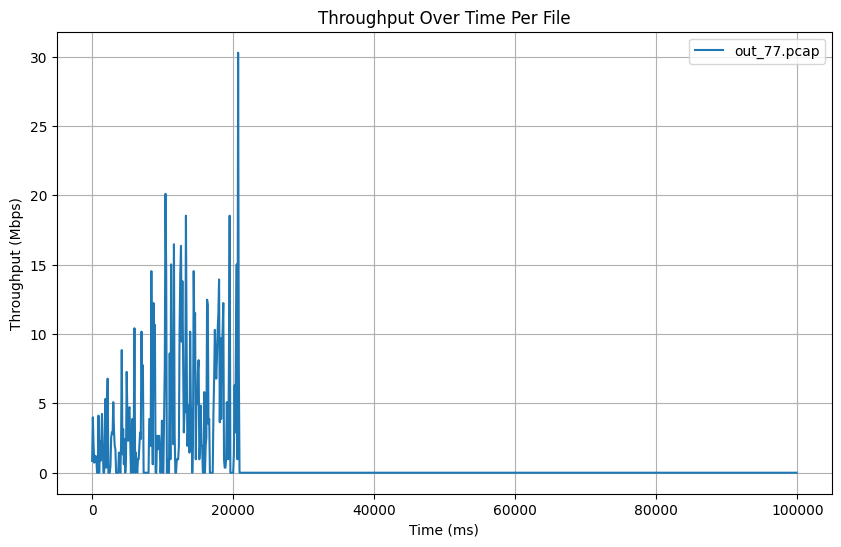

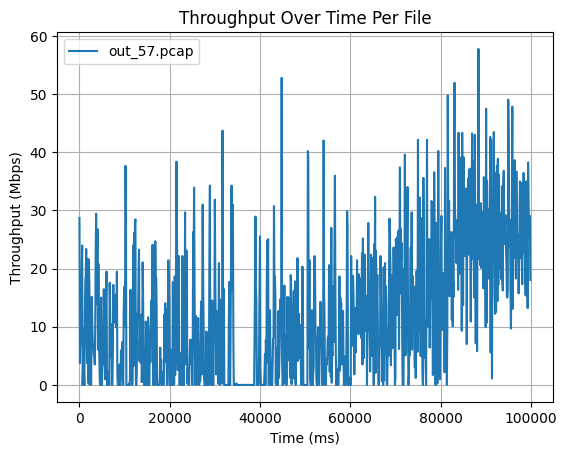

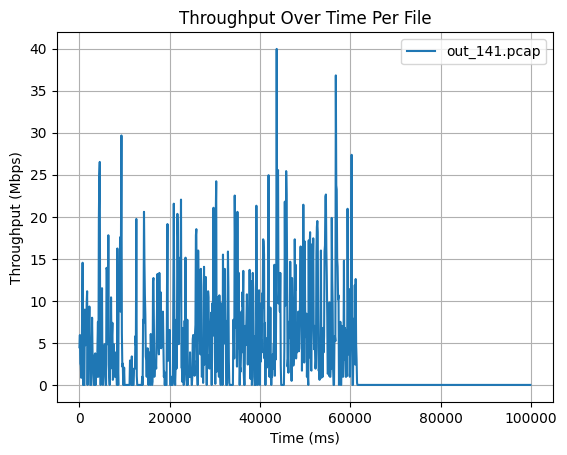

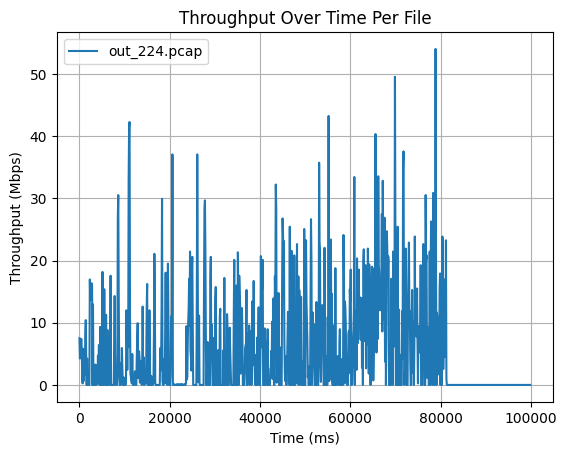

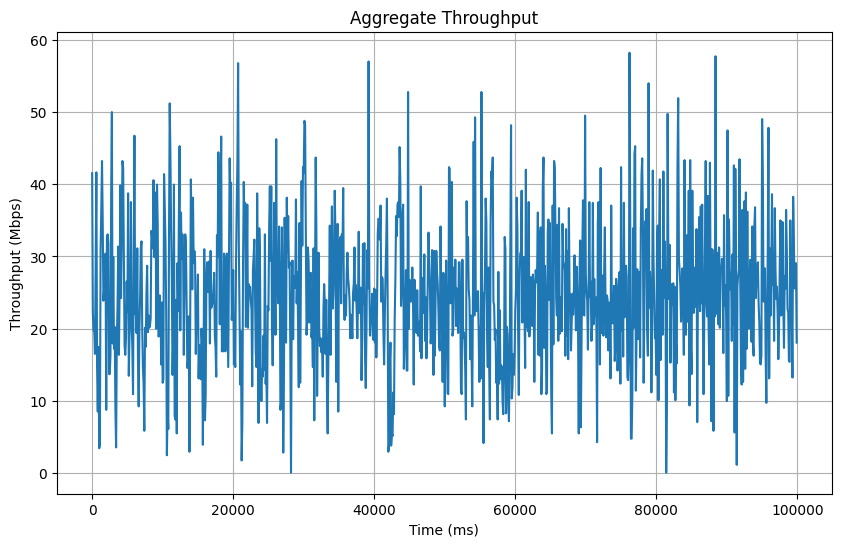

Throughput fraction for out_77.pcap:
  0-20s: 0.1574
  20-40s: 0.0151
  40-60s: 0.0000
  60-80s: 0.0000
  80-100s: 0.0000
Throughput fraction for out_57.pcap:
  0-20s: 0.3295
  20-40s: 0.2662
  40-60s: 0.3306
  60-80s: 0.5425
  80-100s: 0.9732
Throughput fraction for out_139.pcap:
  0-20s: 0.1414
  20-40s: 0.2816
  40-60s: 0.0289
  60-80s: 0.0000
  80-100s: 0.0000
Throughput fraction for out_141.pcap:
  0-20s: 0.1829
  20-40s: 0.2462
  40-60s: 0.3450
  60-80s: 0.0213
  80-100s: 0.0000
Throughput fraction for out_224.pcap:
  0-20s: 0.1888
  20-40s: 0.1910
  40-60s: 0.2955
  60-80s: 0.4362
  80-100s: 0.0268


In [7]:
from scapy.all import *
from datetime import datetime
import math
import matplotlib.pyplot as plt

# Read the base file and store packets to avoid exhaustion
packets = list(PcapReader("./assignment.pcap"))  
if not packets:
    print("Error: No packets found in assignment.pcap")
    exit()
min_time = packets[0].time  

# List of files to analyze
myfile_list = ["out_77.pcap", "out_57.pcap", "out_139.pcap", "out_141.pcap", "out_224.pcap"]
throughput_all = {}

def get_data_transfer_intervals(pcap_file, src_ip, interval_ms=100):
    print(f"Processing {pcap_file}")
    packets = list(PcapReader(pcap_file))  # Convert to list to avoid exhaustion
    if not packets:
        print(f"Warning: No packets found in {pcap_file}")
        return []
    
    total_time = 100  # seconds
    N = int(total_time * 1000 / interval_ms)  
    throughput = [0] * N

    print(f"{pcap_file}: N={N}, Total Packets={len(packets)}")

    for packet in packets:
        packet_time = packet.time
        if len(packet) == 1514:
            offset = packet_time - min_time
            slot = math.floor(offset * 1000 / interval_ms)

            if 0 <= slot < N:
                throughput[slot] += 1

    print(f"{pcap_file}: Throughput Sample (First 10) = {throughput[:10]}")
    return throughput

for file in myfile_list:
    throughput = get_data_transfer_intervals(file, -1, 100)
    if throughput:  # Avoid empty results
        throughput_all[file] = throughput

def throughput_plot_all(myfile_list,throughput_all,interval_ms=100):
    print("Plotting per file throughput")

    plt.figure(figsize=(10, 6))  # Set plot size
    scaling_factor = (1000/interval_ms)*(1514 * 8)/(1000000) 
    # throughput array is packets in that interval; for units = Mbps, packets / (interval = 100ms)*(packet size in bits)/1M 

    for file, throughput in throughput_all.items():
        time_intervals = [i * 100 for i in range(len(throughput))]  # Convert to ms
        plt.plot(time_intervals,[x*scaling_factor for x in throughput], linestyle='-', label=file)  # Unique label

        plt.xlabel("Time (ms)")
        plt.ylabel("Throughput (Mbps)")
        plt.title("Throughput Over Time Per File")
        plt.legend()  # Show file labels
        plt.grid(True)  # Add grid for clarity
        plt.show(block=True)  # Force blocking mode for Matplotlib

# Call the function to plot
throughput_plot_all(myfile_list,throughput_all,100)

def total_throughput(myfile_list,throughput_all,interval_ms=100):
    # throughput_all = get_throughput_all(myfile_list)
    num_intervals = len(next(iter(throughput_all.values())))
    cumulative_throughput = {file: [0] * num_intervals for file in myfile_list}
    aggregate_throughput = [0] * num_intervals

    for file in myfile_list:
        for i in range(num_intervals):
            aggregate_throughput[i] += throughput_all[file][i]

    time_intervals = [i * 100 for i in range(num_intervals)]
    scaling_factor = (1000/interval_ms)*(1514 * 8)/(1000000) 
    # throughput array is packets in that interval; for units = Mbps, packets / (interval = 100ms)*(packet size in bits)/1M 

    plt.figure(figsize=(10,6))
    plt.plot(time_intervals,[x*scaling_factor for x in aggregate_throughput], linestyle='-')
    plt.xlabel("Time (ms)")
    plt.ylabel("Throughput (Mbps)")
    plt.title("Aggregate Throughput")
    plt.grid(True)  # Add grid for clarity
    plt.show(block=True)  # Force blocking mode for Matplotlib

total_throughput(myfile_list,throughput_all,100)

def compute_throughput_fraction(myfile_list, throughput_all, interval_ms=100):
    time_ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
    fraction_results = {file: [] for file in myfile_list}

    for start, end in time_ranges:
        start_idx = start * 1000 // interval_ms
        if start != 0: 
            start_idx += 1 # we don't prevent overlap of [a,b], (b,c] 
        end_idx = end * 1000 // interval_ms

        total_throughput = sum(
            sum(throughput_all[file][start_idx:end_idx]) for file in myfile_list
        )

        for file in myfile_list:
            client_throughput = sum(throughput_all[file][start_idx:end_idx])
            fraction = client_throughput / total_throughput
            fraction_results[file].append((start, end, fraction))

    return fraction_results

# Call the function
throughput_fractions = compute_throughput_fraction(myfile_list, throughput_all)

# Print the results
for file, fractions in throughput_fractions.items():
    print(f"Throughput fraction for {file}:")
    for start, end, fraction in fractions:
        print(f"  {start}-{end}s: {fraction:.4f}")
    